In [1]:
from IPython.display import display, Math, Latex,HTML
%matplotlib inline
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import math
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from glob import glob


# Original Network

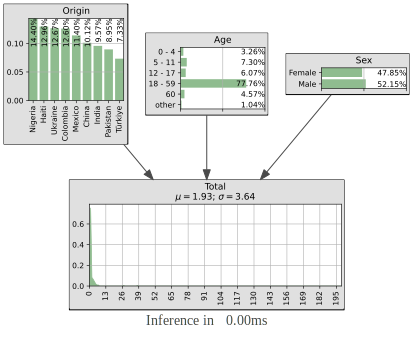

In [2]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
#df2 = df2[df2.Total >= 1000000]
countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break;
        
ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]
sexLabel = ["Female", "Male"]
model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Sex','Sex',sexLabel))

maxRange = 500

nodeList = ["Total"]
rangeNode = {"Total": 200
            }

coeff = {"Total": 1000
        }


bins={n:[i for i in range(maxRange)] for n in nodeList}

for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 100000000
    

model.addArc('Age','Total')
model.addArc('Sex','Total')
model.addArc('Origin','Total')

df3 = df2.sum()

columns = list(df3.index)

model.cpt("Sex")[:]=[df3.loc["Female total"], df3.loc["Male total"]]
model.cpt("Age")[:] = [df3.loc["Female "+lbl] + df3.loc["Male "+lbl] for lbl in ageLabel]
model.cpt("Origin")[:]= [df2.loc[lbl, "Total"] for lbl in countryLabel]
    
for cLabel in countryLabel:
    temp_df = df[df["Country of origin"]==cLabel]
    for gLabel in sexLabel:
        for aLabel in ageLabel:
            temp_dictionary = {"Age":aLabel, "Sex":gLabel,"Origin":cLabel}
            temp =  temp_df.loc[:, gLabel+" " +aLabel]
            temp = np.array(temp)
            
            hist = np.histogram(temp, bins["Total"])[0]
            pr=  hist/sum(hist)
            
            model.cpt("Total")[temp_dictionary]=pr
            
total_model = model
gnb.showInference(total_model, evs={},size="10")    


# Year as Child


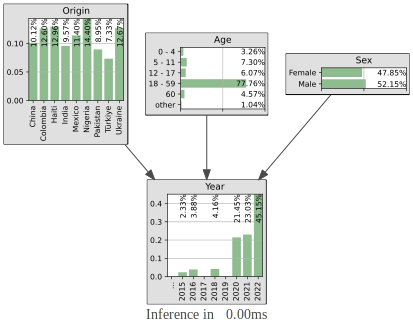

In [3]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break;
        
df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

sexLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Sex','Sex',sexLabel))
yearLabel = [str(i+2001) for i in range(22)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Age','Year')
model.addArc('Sex','Year')
model.addArc('Origin','Year')

df3 = df2.sum()

columns = list(df3.index)

model.cpt("Sex")[:]=[df3.loc["Female total"], df3.loc["Male total"]]
model.cpt("Age")[:] = [df3.loc["Female "+lbl] + df3.loc["Male "+lbl] for lbl in ageLabel]
model.cpt("Origin")[:]= [df2.loc[lbl, "Total"] for lbl in countryLabel]

for cLabel in countryLabel:
    temp_df = df[df["Country of origin"]==cLabel]
    for gLabel in sexLabel:
        for aLabel in ageLabel:
            temp_dictionary = {"Age":aLabel, "Sex":gLabel,"Origin":cLabel}
            temp =  temp_df.loc[:, ["Year", gLabel+" " +aLabel]]
            
            if len(temp) <22:
                for year in range(2001,2023):
                    if (temp["Year"]==year).any() == False:
                        temp.loc[len(temp)]={'Year': year, gLabel+" " +aLabel: 0}
                     
                temp = temp.sort_values("Year")
                
            temp = temp.iloc[:,1]
            temp = np.array(temp)
            model.cpt("Year")[temp_dictionary]=temp

top_model = model
top_model.cpt("Year").normalizeAsCPT()
top_model.cpt("Origin").normalizeAsCPT()
top_model.cpt("Age").normalizeAsCPT()
top_model.cpt("Sex").normalizeAsCPT()

gnb.showInference(top_model, evs={},size="10")

# Year as Parent

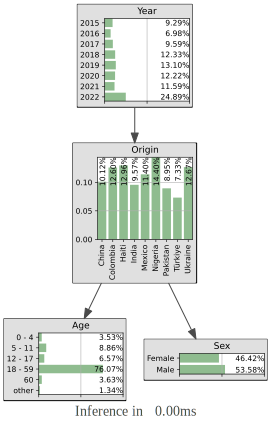

In [4]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

sexLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Sex','Sex',sexLabel))

df2 = df.groupby("Year").sum()
yearLabel = [str(i) for i in df2.index]
model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Year','Origin')
model.addArc('Origin','Age')
model.addArc('Origin','Sex')

model.cpt("Year")[:] = [value for value in df2.loc[:,"Total"]]

year_data = []
for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for cLabel in countryLabel:
        temp_df = df[(df["Country of origin"]==cLabel) & (df["Year"]==int(year))]
        
        if len(temp_df) == 0:
            temp = 0
        else:
            temp = temp_df.iloc[0]["Total"]
            
        origin_data.append(temp)
    
    year_data.append(np.sum(origin_data))
    model.cpt("Origin")[year_dictionary] = origin_data
    
df3 = df.groupby("Country of origin").sum()
female = np.array(df3.iloc[:]["Female total"])
male = fem = np.array(df3.iloc[:]["Male total"])

model.cpt("Sex")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df3.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in sexLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model.cpt("Age")[{"Origin":cLabel}] = age_data

model.cpt("Year").normalizeAsCPT()
model.cpt("Origin").normalizeAsCPT()
model.cpt("Age").normalizeAsCPT()
model.cpt("Sex").normalizeAsCPT()

bot_model = model
gnb.showInference(bot_model, evs={},size="10")    

# ESR Model


In [5]:
model = gum.BayesNet()

initYear = 2016
yearLabel = [str(i+initYear) for i in range(7)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

nodeList = ["Economic",
            "Sponsor",
            "Refugee",
           ]

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]
model.add(gum.LabelizedVariable('Province','Province',provinceLabel))

rangeNode = {"Economic": 150,
             "Sponsor": 70,
             "Refugee": 50,
            }

coeff = {"Economic": 100,
         "Sponsor": 100,
         "Refugee": 100,
        }
for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 1000000

model.addArc('Province','Sponsor')
model.addArc('Province','Refugee')
model.addArc('Province','Economic')

model.addArc('Year','Sponsor')
model.addArc('Year','Refugee')
model.addArc('Year','Economic')

model.addArc('Year','Province')

model

(pyAgrum.BayesNet<double>@0000022E4C52AEC0) BN{nodes: 5, arcs: 7, domainSize: 10^7.56526, dim: 18759, mem: 148Ko 264o}

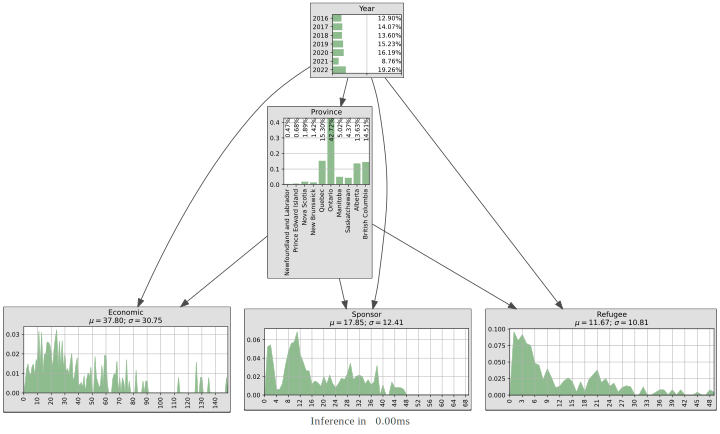

In [6]:
df = {}
pr = {p:{y:0 for y in provinceLabel} for p in yearLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]
    
    for year in yearLabel:
        year_diff = int(year)-initYear
        pr[year][p] = np.sum(df[p].Total[year_diff*12: (year_diff+1) * 12])

year_data = []
for y in yearLabel:
    model.cpt("Province")[{"Year":y}]= pr[y]
    year_data.append(sum(pr[y].values()))
model.cpt("Year")[:] =year_data 


pr = {p:{y:{d:0 for d in rangeNode.keys()} for y in yearLabel} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    province_df = data.iloc[:,1:]
    
    for yIndex, y in enumerate(yearLabel):
        yearly_province_df = province_df.iloc[yIndex*12:(yIndex+1)*12]
        
        for d in nodeList:
            arr = np.array(yearly_province_df[d])

            hist = np.histogram(arr, bins[d])[0]
            pr[p][y][d]=  hist/sum(hist)
        
for index, p in enumerate(provinceLabel):
    for yIndex, y in enumerate(yearLabel):
        dictionary={"Province":p,"Year":y}
        model.cpt("Economic")[dictionary] = pr[p][y]["Economic"]
        model.cpt("Sponsor")[dictionary] = pr[p][y]["Sponsor"]
        model.cpt("Refugee")[dictionary] = pr[p][y]["Refugee"]   
        
model.cpt("Year").normalizeAsCPT()
model.cpt("Province").normalizeAsCPT()
model.cpt("Refugee").normalizeAsCPT()
model.cpt("Sponsor").normalizeAsCPT()
model.cpt("Economic").normalizeAsCPT()

esr_model = model
gnb.showInference(esr_model, evs={},size="10")


# Education Network

In [22]:
model = gum.BayesNet()

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]
sexLabel = ["Female", "Male"]
educationLabel = ['0 to 8  years', 'Some high school',
       'High school graduate', 'Some postsecondary',
       'Postsecondary certificate or diploma', 'University degree']

initYear = 2016               
yearLabel = [str(initYear+index) for index in range(7)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 
model.add(gum.LabelizedVariable('Sex','Sex',sexLabel)) 
model.add(gum.LabelizedVariable('Education','Education',educationLabel)) 
model.add(gum.LabelizedVariable('Province','Province',provinceLabel)) 
model.add(gum.NumericalDiscreteVariable('Employment Rate','Employment Rate',range(0,101))) 

model.addArc('Province','Employment Rate')
model.addArc('Sex','Employment Rate')
model.addArc('Education','Employment Rate')

model.addArc('Year','Employment Rate')

model.cpt("Province").fillWith(1)
model.cpt("Sex").fillWith(1)
model.cpt("Education").fillWith(1)
model.cpt("Year").fillWith(1)

model

(pyAgrum.BayesNet<double>@0000022E53682430) BN{nodes: 5, arcs: 4, domainSize: 84840, dim: 84021, mem: 663Ko 8o}

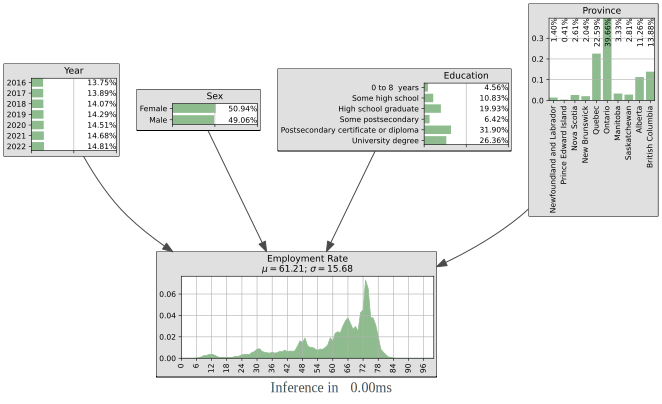

In [34]:
population_df = pd.read_csv("population_education.csv")
er_df = pd.read_csv("employment_education.csv")

population_df = population_df.loc[:, ["REF_DATE","GEO","Sex","Educational attainment","VALUE"]]
population_df.columns = ["Date", "Province", "Sex", "Education","Population"]

er_df = er_df.loc[:, ["VALUE"]]
er_df.columns = ["Employment Rate"]

pop_er_df = population_df.join(er_df)

temp = pop_er_df
temp = temp.loc[:,"Population"] * temp.loc[:,"Employment Rate"]/100

pop_er_df = pop_er_df.join(pd.DataFrame(temp, columns=["Population ER"]))

canada_df = pop_er_df[pop_er_df["Province"]=="Canada"]
model.cpt("Sex")[:] = [canada_df.groupby("Sex").mean().Population[0], canada_df.groupby("Sex").mean().Population[1]]

avg_df = pop_er_df[(pop_er_df["Province"]=="Canada") & (pop_er_df["Education"]=="Total, all education levels")]
avg_df = avg_df.groupby(["Date","Sex"]).mean()
avg_df = avg_df.groupby("Date").sum()

year_data = []
for y in yearLabel:
    index = int(y) - initYear
    year_data.append(np.sum(avg_df.iloc[index*12: (index+1)*12].Population))
    
model.cpt("Year")[:] = year_data

avg_df =  canada_df.groupby(["Education","Sex"]).mean()
avg_df =  avg_df.groupby("Education").sum()
for education in educationLabel:
    dictionary = {"Education":education}
    model.cpt("Education")[dictionary] = avg_df.loc[education, "Population"]

avg_df =  pop_er_df.groupby("Province").mean()
for province in provinceLabel:
    dictionary = {"Province":province}
    model.cpt("Province")[dictionary] = avg_df.loc[province, "Population"]/avg_df.loc["Canada", "Population"]

avg_df =  pop_er_df.groupby(["Province","Sex","Education","Date"]).mean()    
for province in provinceLabel:
    for sex in sexLabel:
        for education in educationLabel:
            yearly_province_df = avg_df.loc[province].loc[sex+"s"].loc[education]
            for index, year in enumerate(yearLabel):
                dictionary = {"Year":year, "Sex":sex, "Province":province, "Education":education}

                arr = np.array(yearly_province_df.iloc[index*12:(index+1)*12,1])
                arr = arr[~np.isnan(arr)]
                hist = np.histogram(arr, 101, (0,100))[0]
                data =  hist/sum(hist)
                model.cpt("Employment Rate")[dictionary] = data

# for province in provinceLabel:
#     temp_df = pop_er_df[pop_er_df["Province"]==province] 
#     for sex in sexLabel:
#         for education in educationLabel:
#             dictionary = {"Sex":gender, "Province":province, "Education":education}
            
#             yearly_province_df = temp_df[(temp_df["Sex"]==sex+"s") & (temp_df["Education"]==education)]
#             arr = np.array(yearly_province_df.loc[:,"Employment Rate"])
#             arr = arr[~np.isnan(arr)]
#             hist = np.histogram(arr, 101, (0,100))[0]
#             data =  hist/sum(hist)
            
#             model.cpt("Employment Rate")[dictionary] = data
            
model.cpt("Sex").normalizeAsCPT()
model.cpt("Province").normalizeAsCPT()
# model.cpt("Education").normalizeAsCPT()
model.cpt("Year").normalizeAsCPT()
model.cpt("Employment Rate").normalizeAsCPT()

edu_model = model            
gnb.showInference(model, evs={},size="10")

In [35]:
canada_df

,Date,Province,Sex,Education,Population,Employment Rate,Population ER
0,2015-01,Canada,Males,"Total, all education levels",14285.0,64.0,9142.4000
1,2015-02,Canada,Males,"Total, all education levels",14291.8,64.2,9175.3356
2,2015-03,Canada,Males,"Total, all education levels",14299.6,64.1,9166.0436
3,2015-04,Canada,Males,"Total, all education levels",14308.2,64.5,9228.7890
4,2015-05,Canada,Males,"Total, all education levels",14317.8,66.4,9507.0192
...,...,...,...,...,...,...,...
1723,2022-08,Canada,Females,Above bachelor's degree,1567.6,74.2,1163.1592
1724,2022-09,Canada,Females,Above bachelor's degree,1536.4,75.1,1153.8364
1725,2022-10,Canada,Females,Above bachelor's degree,1552.1,75.6,1173.3876
1726,2022-11,Canada,Females,Above bachelor's degree,1585.7,76.4,1211.4748


In [31]:
a = canada_df.groupby(["Education","Sex"]).mean()
a.groupby("Education").sum()

,Population,Employment Rate,Population ER
Education,,,
0 to 8 years,1385.943750,40.091667,271.695927
Above bachelor's degree,2559.126042,148.839583,1905.337690
Bachelor's degree,5456.713542,147.583333,4011.960024
High school graduate,6059.856250,113.261458,3435.041719
Postsecondary certificate or diploma,9702.037500,135.938542,6588.047209
Some high school,3295.037500,75.459375,1255.875344
Some postsecondary,1952.907292,116.544792,1136.170075
"Total, all education levels",30411.620833,122.463542,18603.827590
University degree,8015.858333,147.900000,5917.547003


In [9]:
gnb.sideBySide(gnb.getInference(model, evs={"Sex":"Female","Province":"Alberta","Education":"0 to 8  years"},size="10"), gnb.getInference(model, evs={"Province":"Quebec"},size="10"))

# Employment for Immigration Status

In [20]:
model = gum.BayesNet()

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]

statusLabel = ['Born in Canada', 'Immigrants, landed 5 or less years earlier',
               'Immigrants, landed more than 10 years earlier',
               'Immigrants, landed more than 5 to 10 years earlier']
initYear = 2016               
yearLabel = [str(initYear+index) for index in range(7)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 
model.add(gum.LabelizedVariable('Status','Status',statusLabel)) 
model.add(gum.LabelizedVariable('Province','Province',provinceLabel)) 
model.add(gum.NumericalDiscreteVariable('Employment Rate','Employment Rate',range(0,101))) 

model.addArc('Province','Employment Rate')
model.addArc('Status','Employment Rate')
model.addArc('Year','Employment Rate')

model.cpt("Province").fillWith(1)
model.cpt("Status").fillWith(1)
model.cpt("Year").fillWith(1)

model

(pyAgrum.BayesNet<double>@0000022E53680150) BN{nodes: 4, arcs: 3, domainSize: 28280, dim: 28018, mem: 221Ko 104o}

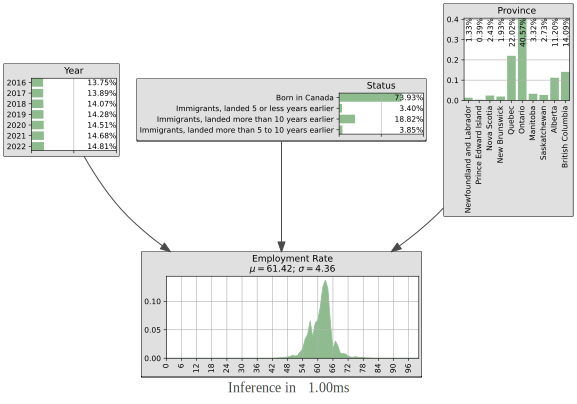

In [21]:
population_df = pd.read_csv("population_immigration.csv")
er_df = pd.read_csv("employment_immigration.csv")

population_df = population_df.loc[:, ["REF_DATE","GEO","Immigrant status","VALUE"]]
population_df.columns = ["Date", "Province", "Status","Population"]

er_df = er_df.loc[:, ["VALUE"]]
er_df.columns = ["Employment Rate"]

pop_er_df = population_df.join(er_df)

temp = pop_er_df
temp = temp.loc[:,"Population"] * temp.loc[:,"Employment Rate"]/100

pop_er_df = pop_er_df.join(pd.DataFrame(temp, columns=["Population ER"]))

canada_df = pop_er_df[pop_er_df["Province"]=="Canada"]

model.cpt("Status")[:] = [canada_df.groupby("Status").mean().Population[i] for i in range(len(statusLabel))]

avg_df =  pop_er_df.groupby("Province").mean()
for province in provinceLabel:
    dictionary = {"Province":province}
    model.cpt("Province")[dictionary] = avg_df.loc[province, "Population"]/avg_df.loc["Canada", "Population"]

avg_df = pop_er_df[(pop_er_df["Province"]=="Canada") & (pop_er_df["Status"]=="Total population")]
avg_df = avg_df.groupby("Date").mean()

year_data = []
for y in yearLabel:
    index = int(y) - initYear
    year_data.append(np.sum(avg_df.iloc[index*12: (index+1)*12].Population))
    
model.cpt("Year")[:] = year_data

avg_df=  pop_er_df.groupby(["Province","Status","Date"]).mean()

for province in provinceLabel:
    for status in statusLabel:
        yearly_province_df = avg_df.loc[province].loc[status]
        
        for index, year in enumerate(yearLabel):
            dictionary = {"Year":year, "Province":province, "Status":status}

            arr = np.array(yearly_province_df.iloc[index*12:(index+1)*12,1])
            arr = arr[~np.isnan(arr)]
            hist = np.histogram(arr, 101, (0,100))[0]
            data =  hist/sum(hist)

            model.cpt("Employment Rate")[dictionary] = data

# avg_df=  pop_er_df.groupby(["Province","Status","Date"]).mean()

# for province in provinceLabel:
#     for status in statusLabel:
#         yearly_province_df = avg_df.loc[province].loc[status]
#         dictionary = {"Province":province, "Status":status}

#             arr = np.array(yearly_province_df.iloc[:,1])
#             arr = arr[~np.isnan(arr)]
#             hist = np.histogram(arr, 101, (0,100))[0]
#             data =  hist/sum(hist)

#             model.cpt("Employment Rate")[dictionary] = data

model.cpt("Year").normalizeAsCPT()
model.cpt("Province").normalizeAsCPT()
model.cpt("Status").normalizeAsCPT()
model.cpt("Employment Rate").normalizeAsCPT()

imm_model = model            
gnb.showInference(imm_model, evs={},size="10")            
       

# Credal Network


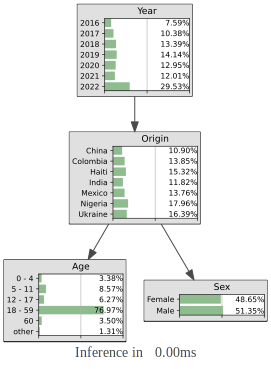

In [12]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:8]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

sexLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Sex','Sex',sexLabel))
yearLabel = [str(i+2001) for i in range(22)]

yearLabel = [str(i+2016) for i in range(7)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Year','Origin')
model.addArc('Origin','Age')
model.addArc('Origin','Sex')

#populate gender/origin/age/year

df2 = df.groupby("Year").sum()
year_values = [value for value in df2.loc[:,"Total"]]
model.cpt("Year")[:] = year_values[-len(yearLabel):]

year_data = []
for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for cLabel in countryLabel:
        temp_df = df[(df["Country of origin"]==cLabel) & (df["Year"]==int(year))]
        
        if len(temp_df) == 0:
            temp = 0
        else:
            temp = temp_df.iloc[0]["Total"]
            
        origin_data.append(temp)
    
#     year_data.append(np.sum(origin_data))
    model.cpt("Origin")[year_dictionary] = origin_data
    
df3 = df.groupby("Country of origin").sum()
female = np.array(df3.iloc[:]["Female total"])
male = fem = np.array(df3.iloc[:]["Male total"])

model.cpt("Sex")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df3.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in sexLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model.cpt("Age")[{"Origin":cLabel}] = age_data

model.cpt("Year").normalizeAsCPT()
model.cpt("Origin").normalizeAsCPT()
model.cpt("Age").normalizeAsCPT()
model.cpt("Sex").normalizeAsCPT()  

refugee_model = model
gnb.showInference(refugee_model)  


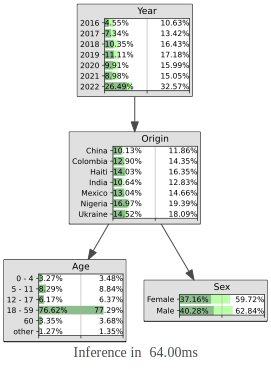

In [13]:
bn_min=gum.BayesNet(refugee_model)
bn_max=gum.BayesNet(refugee_model)
for n in refugee_model.nodes():
  x=0.4*min(refugee_model.cpt(n).min(),1-refugee_model.cpt(n).max())
  bn_min.cpt(n).translate(-x)
  bn_max.cpt(n).translate(x)

cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()
ie_mc=gum.CNMonteCarloSampling(cn)
gnb.showInference(cn,engine=ie_mc)

# cn2=gum.CredalNet(bn_min,bn_max)
# cn2.intervalToCredal()
# cn2.approximatedBinarization()
# cn2.computeBinaryCPTMinMax()

# ie_mc=gum.CNMonteCarloSampling(cn2)
# gnb.showInference(cn2,engine=ie_mc)

In [14]:
def nodevalue(n, default=-1):
    value = 0
    
    if n in edu_model.names():
        value = 0.2
        if default == 0:
            return value
        
    if n in esr_model.names():
        value = 0.7
        if default == 1:
            return value
        
    if n in refugee_model.names():
        value = 0.8
        if default == 2:
            return value

    if n in imm_model.names():
        value = 0.4
        if default == 3:
            return value
        
    if n in {"Gender","Year","Province"}:
        value = 1
        
    return value


import pyAgrum.lib.image as gumimage

# model = gum.BayesNet()
# model.add(gum.NumericalDiscreteVariable('0','0',[0,1])) 
# for i in range(1,10):
#     model.add(gum.NumericalDiscreteVariable(str(i/10),str(i/10),[0,1])) 
#     model.addArc("0",str(i/10))
#     model.cpt(str(i/10)).fillWith(1)
# model.cpt("0").fillWith(1)
    
# gumimage.exportInference(model,"color.pdf",
#                          targets={},evs={},
#                          nodeColor={n:float(n) for n in model.names()})    

gumimage.exportInference(edu_model,"bn_edu.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n,0) for n in edu_model.names()})

gumimage.exportInference(esr_model,"bn_pr.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n,1) for n in esr_model.names()})

gumimage.exportInference(cn,"credal_refugee.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n,2) for n in refugee_model.names()})

gumimage.exportInference(imm_model,"bn_imm.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n,3) for n in imm_model.names()})

gumimage.exportInference(refugee_model,"bn_refugee.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n,2) for n in refugee_model.names()})


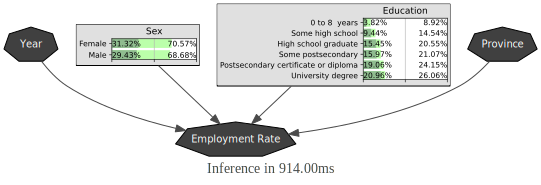

In [15]:
bn_min=gum.BayesNet(edu_model)
bn_max=gum.BayesNet(edu_model)
for n in edu_model.nodes():
    x=0.4*min(edu_model.cpt(n).min(),1-edu_model.cpt(n).max())
    bn_min.cpt(n).translate(-x)
    bn_max.cpt(n).translate(x)

cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()
ie_mc=gum.CNMonteCarloSampling(cn)
gnb.showInference(cn,targets={"Sex","Education"},engine=ie_mc)

gumimage.exportInference(cn,"credal_edu.pdf",
                         targets={"Sex","Education"},evs={},
                         nodeColor={n:nodevalue(n,0) for n in edu_model.names()})

In [16]:
gnb.flow.row(edu_model.cpt("Province"),bn_min.cpt("Province"),bn_max.cpt("Province"),captions=["CPT","CPTmin","CPTmax"])

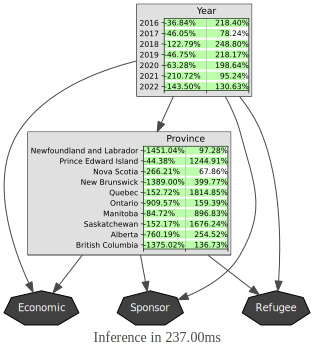

In [17]:


bn_min=gum.BayesNet(esr_model)
bn_max=gum.BayesNet(esr_model)
for n in esr_model.nodes():
    x=0.4*min(esr_model.cpt(n).min(),1-esr_model.cpt(n).max())
    bn_min.cpt(n).translate(-x)
    bn_max.cpt(n).translate(x)

cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()
ie_mc=gum.CNMonteCarloSampling(cn)
gnb.showInference(cn,targets={"Year","Province"},engine=ie_mc)

# gumimage.exportInference(cn,"credal_esr.pdf",
#                          targets={"Sex","Education"},evs={},
#                          nodeColor={n:nodevalue(n,0) for n in edu_model.names()})

In [18]:
bn_min.cpt("Year")

(pyAgrum.Potential<double>@0000022E52259520) 
  Year                                                               |
2016     |2017     |2018     |2019     |2020     |2021     |2022     |
---------|---------|---------|---------|---------|---------|---------|
 0.0939  | 0.1056  | 0.1009  | 0.1173  | 0.1268  | 0.0526  | 0.1575  |

In [19]:
bn_max.cpt("Year")

(pyAgrum.Potential<double>@0000022E52259460) 
  Year                                                               |
2016     |2017     |2018     |2019     |2020     |2021     |2022     |
---------|---------|---------|---------|---------|---------|---------|
 0.1640  | 0.1757  | 0.1710  | 0.1874  | 0.1969  | 0.1227  | 0.2276  |